SDV 모델을 이용한 공모전 추천 시스템
추천 시스템 구현을 위한 환경

In [3]:
pip install numpy pandas matplotlib seaborn scikit-learn scipy ipython setuptools


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.0/11.0 MB 3.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.1/23.1 MB 2.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.8/301.8 kB 2.4 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.3.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [5]:
import random as rd
import pandas as pd

import sklearn
import scipy
import matplotlib

from sklearn.decomposition import TruncatedSVD
from scipy.sparse.linalg import svds

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')

from matplotlib import font_manager, rc
from matplotlib import style
style.use('ggplot')
%matplotlib inline

# MacBook에서 폰트 설정
rc('font', family='Apple SD Gothic Neo')  # macOS 기본 한글 폰트

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')


In [6]:
print('sklearn : {}'.format(sklearn.__version__))
print('scipy : {}'.format(scipy.__version__))
print('pandas : {}'.format(pd.__version__))
print('matplotlib : {}'.format(matplotlib.__version__))
print('seaborn : {}'.format(sns.__version__))

sklearn : 1.5.2
scipy : 1.14.1
pandas : 2.1.0
matplotlib : 3.9.2
seaborn : 0.13.2


## 지금은 유저 데이터가 없으니까 임의로 생성하기
이 코드를 실행하는 목적
모델 테스트 및 알고리즘 학습
랜덤 데이터를 기반으로 추천 시스템(예: 협업 필터링)이나 머신러닝 알고리즘을 학습하고 테스트하기 위한 샘플 데이터 생성.

데이터 분석 연습
실제 데이터가 없는 상황에서 데이터 전처리, 탐색적 데이터 분석(EDA), 시각화 기법을 연습하기 위함.

추천 시스템 구현
user_id, gong_id, gong_rank 데이터를 기반으로 추천 알고리즘(예: Matrix Factorization, SVD)을 구현하는 데 사용됩니다.


이 코드의 전체 흐름은 랜덤 데이터 생성 → 데이터 정제 → 데이터 분석 및 알고리즘 테스트의 과정


In [15]:
# user_id, gong_id 생성 [랜덤 데이터를 생성하는 이유: 실제 데이터가 없는 상황에서 모델링, 분석, 또는 테스트를 위해 사용합니다]
user_id = [rd.randint(1, 10000) for _ in range(100000)]
gong_id = [rd.randint(1, 14450) for _ in range(100000)]

# DataFrame 생성 및 중복 제거 [데이터에서 중복이 제거되지 않으면 분석 결과가 왜곡될 수 있습니다.]
user_info = pd.DataFrame({'user_id': user_id, 'gong_id': gong_id}).drop_duplicates()

# gong_rank 생성 및 추가 [추천 시스템이나 분석 모델에서 사용자-항목 간 선호도를 표현하는 변수로 사용]
user_info['gong_rank'] = [rd.randint(1, 10) for _ in range(len(user_info))]

# 생성된 데이터를 CSV 파일로 저장
user_info.to_csv('./user_info.csv', index=False, encoding='utf-8-sig')
print("Data saved to user_info.csv")

Data saved to user_info.csv


In [40]:
user_info = pd.read_csv('./user_info.csv')
gong_info = pd.read_json('./competitions.json', orient='records')


## 분류에 따른 아이템별 추천
함수 사용법
gongmo_recommend(juchae, money, title) : 고른 아이템과 비슷한 공모전들을 추천해줌
juchae : 주최기관, money : 상금규모, title : 공모전명

In [47]:
def gongmo_recommend(juchae, money, title):
    # 원하는 정보만 뽑음
    gong_temp = gong_info[gong_info[organizer].str.contains(organizer, na=False)]
    gong_temp = gong_temp[gong_temp[prize].str.contains(prize, na=False)]

    
    # rank 기준
    user_data = user_info.copy()
    gong_data = gong_want[['gong_id', '공모명']].copy()
    
    # SVD 적용하기 좋은 모습으로 변경
    user_gong_data = pd.merge(user_data, gong_data, on = 'gong_id')
    user_gong_rating = user_gong_data.pivot_table('gong_rank',
                    index = 'user_id', columns = '공모전명').fillna(0)
    user_user_rating = user_gong_rating.values.T
    
    # 시그마에서 상위 12개 element만 추출
    SVD = TruncatedSVD(n_components = 12)
    matrix = SVD.fit_transform(user_user_rating)
    
    # 상관계수 도출
    corr = np.corrcoef(matrix)
    
    # 시각화
    plt.figure(figsize=(16, 10))
    sns.heatmap(corr)
    plt.show()
    
    gong_title = user_gong_rating.columns
    gong_title_list = list(gong_title)
    coffey_hands = gong_title_list.index(title)
    
    # 비슷할 확률이 80% 이상인 공모전들만 반환
    corr_coffey_hands  = corr[coffey_hands]
    recommend_list = list(gong_title[(corr_coffey_hands >= 0.8)])
    if title in recommend_list :
        recommend_list.remove(title)
        
    return recommend_list

gongmo_recommend('곰앤컴퍼니', '50만원', '[곰랩x땅땅치킨] 우리 반 편집했S 영상 콘테스트 공모전SPECIAL')


NameError: name 'organizer' is not defined

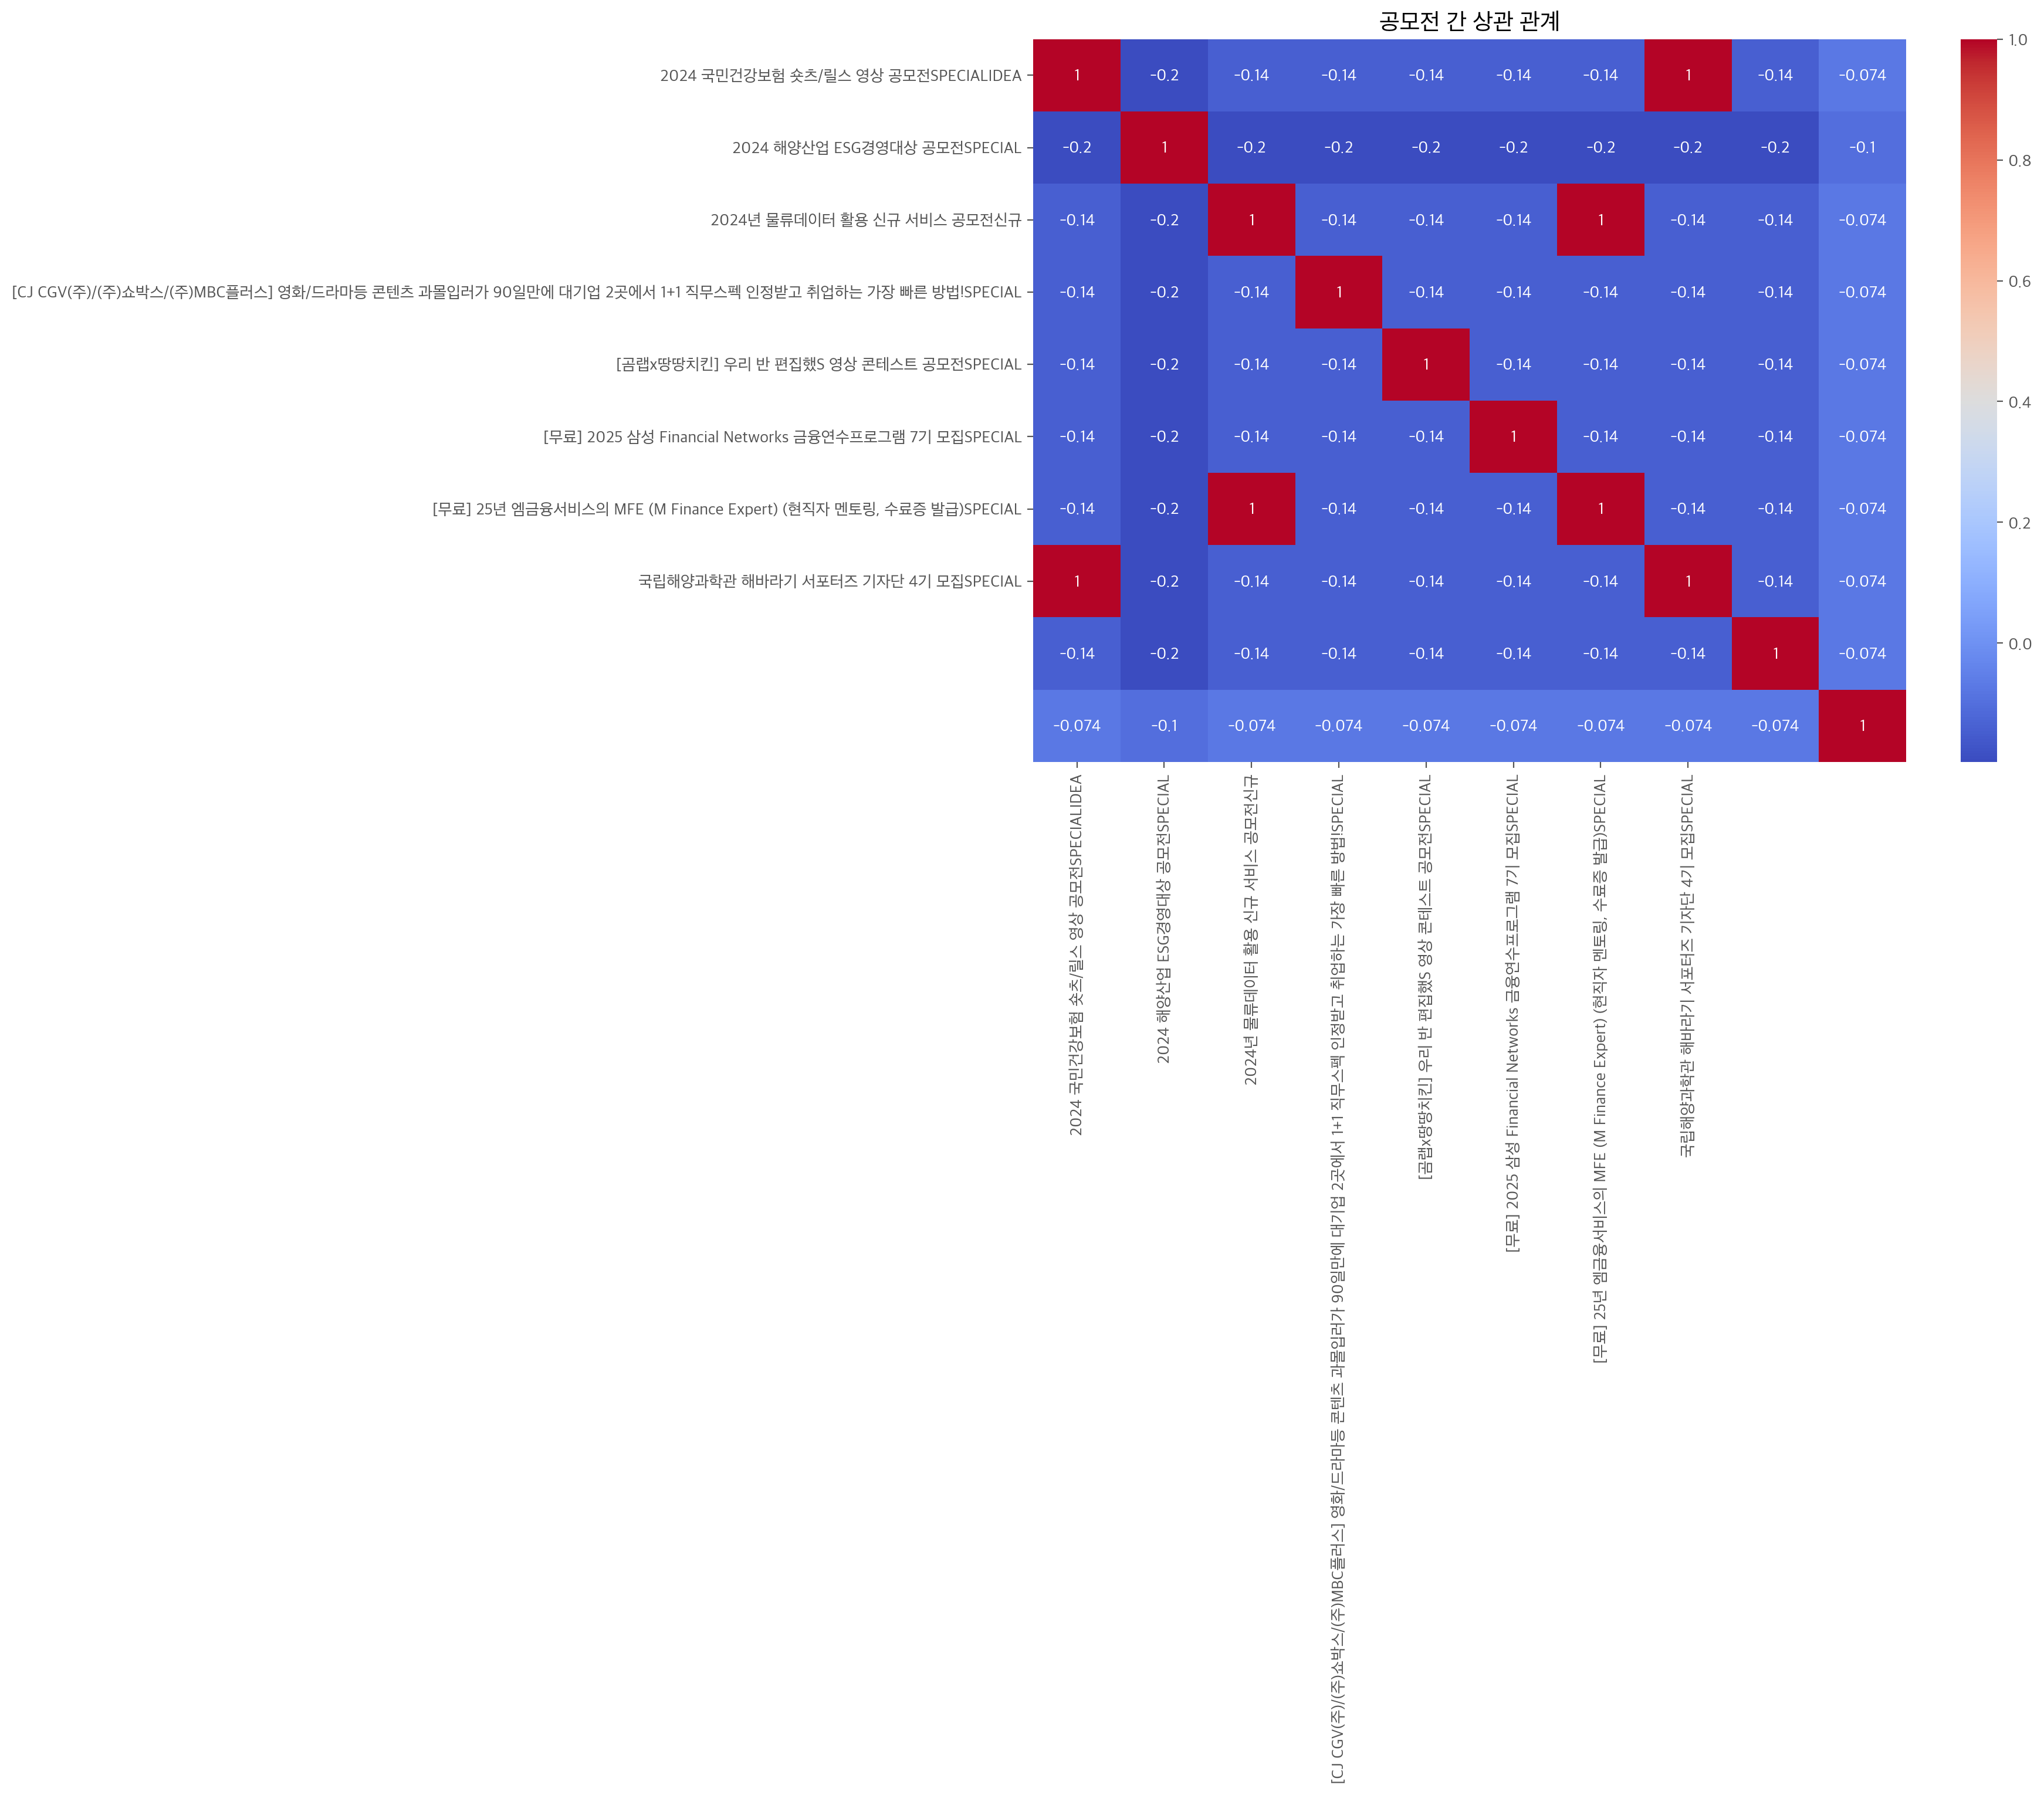

'제29회 농민신문 신춘문예 작품 공모전SPECIAL' 공모전은 목록에 없습니다.
추천된 공모전들: []


In [51]:
import random as rd
import pandas as pd
import numpy as np
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# 데이터 로드 (공모전 데이터)
gong_info = pd.read_csv('./competitions.csv')

# 임의 유저 데이터 생성 (예시)
# 실제 유저 데이터는 각 공모전에 대한 관심도나 평점 등으로 대체되어야 합니다.
# 여기서는 임의로 각 공모전의 관심도를 평가하는 방식으로 생성합니다.
user_info = pd.DataFrame({
    'user_id': [f'user_{i}' for i in range(1, 11)],  # 10명의 사용자
    'gong_id': [rd.choice(gong_info.index) for _ in range(10)],  # 임의로 공모전 선택
    'gong_rank': [rd.randint(1, 5) for _ in range(10)]  # 임의로 1~5까지의 평가
})

# 공모전 데이터 가공 (필요한 열만 추출)
gong_data = gong_info[['공모명', '주최 기관', '분야']].copy()
gong_data['gong_id'] = gong_info.index  # 고유한 공모전 ID 추가

# 사용자-공모전 행렬 생성
user_gong_data = pd.merge(user_info, gong_data, on='gong_id')

# 사용자-공모전 평점 행렬 생성 (결측치는 0으로 채운다)
user_gong_rating = user_gong_data.pivot_table('gong_rank', index='user_id', columns='공모명').fillna(0)

# SVD 모델 적용
n_components = min(12, user_gong_rating.shape[1])  # 공모전 수보다 더 큰 n_components를 방지
SVD = TruncatedSVD(n_components=n_components)  # 주성분 개수를 공모전 수에 맞게 설정
matrix = SVD.fit_transform(user_gong_rating.values)

# 유사도 계산 (공모전 간 상관 관계)
corr = np.corrcoef(matrix)

# 시각화
plt.figure(figsize=(12, 8))
sns.heatmap(corr, cmap='coolwarm', annot=True, xticklabels=user_gong_rating.columns, yticklabels=user_gong_rating.columns)
plt.title('공모전 간 상관 관계')
plt.show()

# 추천 함수 정의
def recommend_competitions(user_title, corr_matrix, gong_titles, threshold=0.8):
    # 입력된 공모전 제목의 인덱스 찾기
    if user_title not in gong_titles:
        print(f"'{user_title}' 공모전은 목록에 없습니다.")
        return []
    
    idx = gong_titles.index(user_title)
    
    # 해당 공모전과 유사도가 높은 공모전 찾기 (threshold 이상)
    similar_competitions = []
    for i, score in enumerate(corr_matrix[idx]):
        if score >= threshold and gong_titles[i] != user_title:
            similar_competitions.append(gong_titles[i])
    
    return similar_competitions

# 예시: '컴투스 글로벌 게임개발 공모전 컴:온 2024SPECIAL'와 비슷한 공모전 찾기
gong_titles = list(user_gong_rating.columns)
similar_comps = recommend_competitions('제29회 농민신문 신춘문예 작품 공모전SPECIAL', corr, gong_titles)

print("추천된 공모전들:", similar_comps)


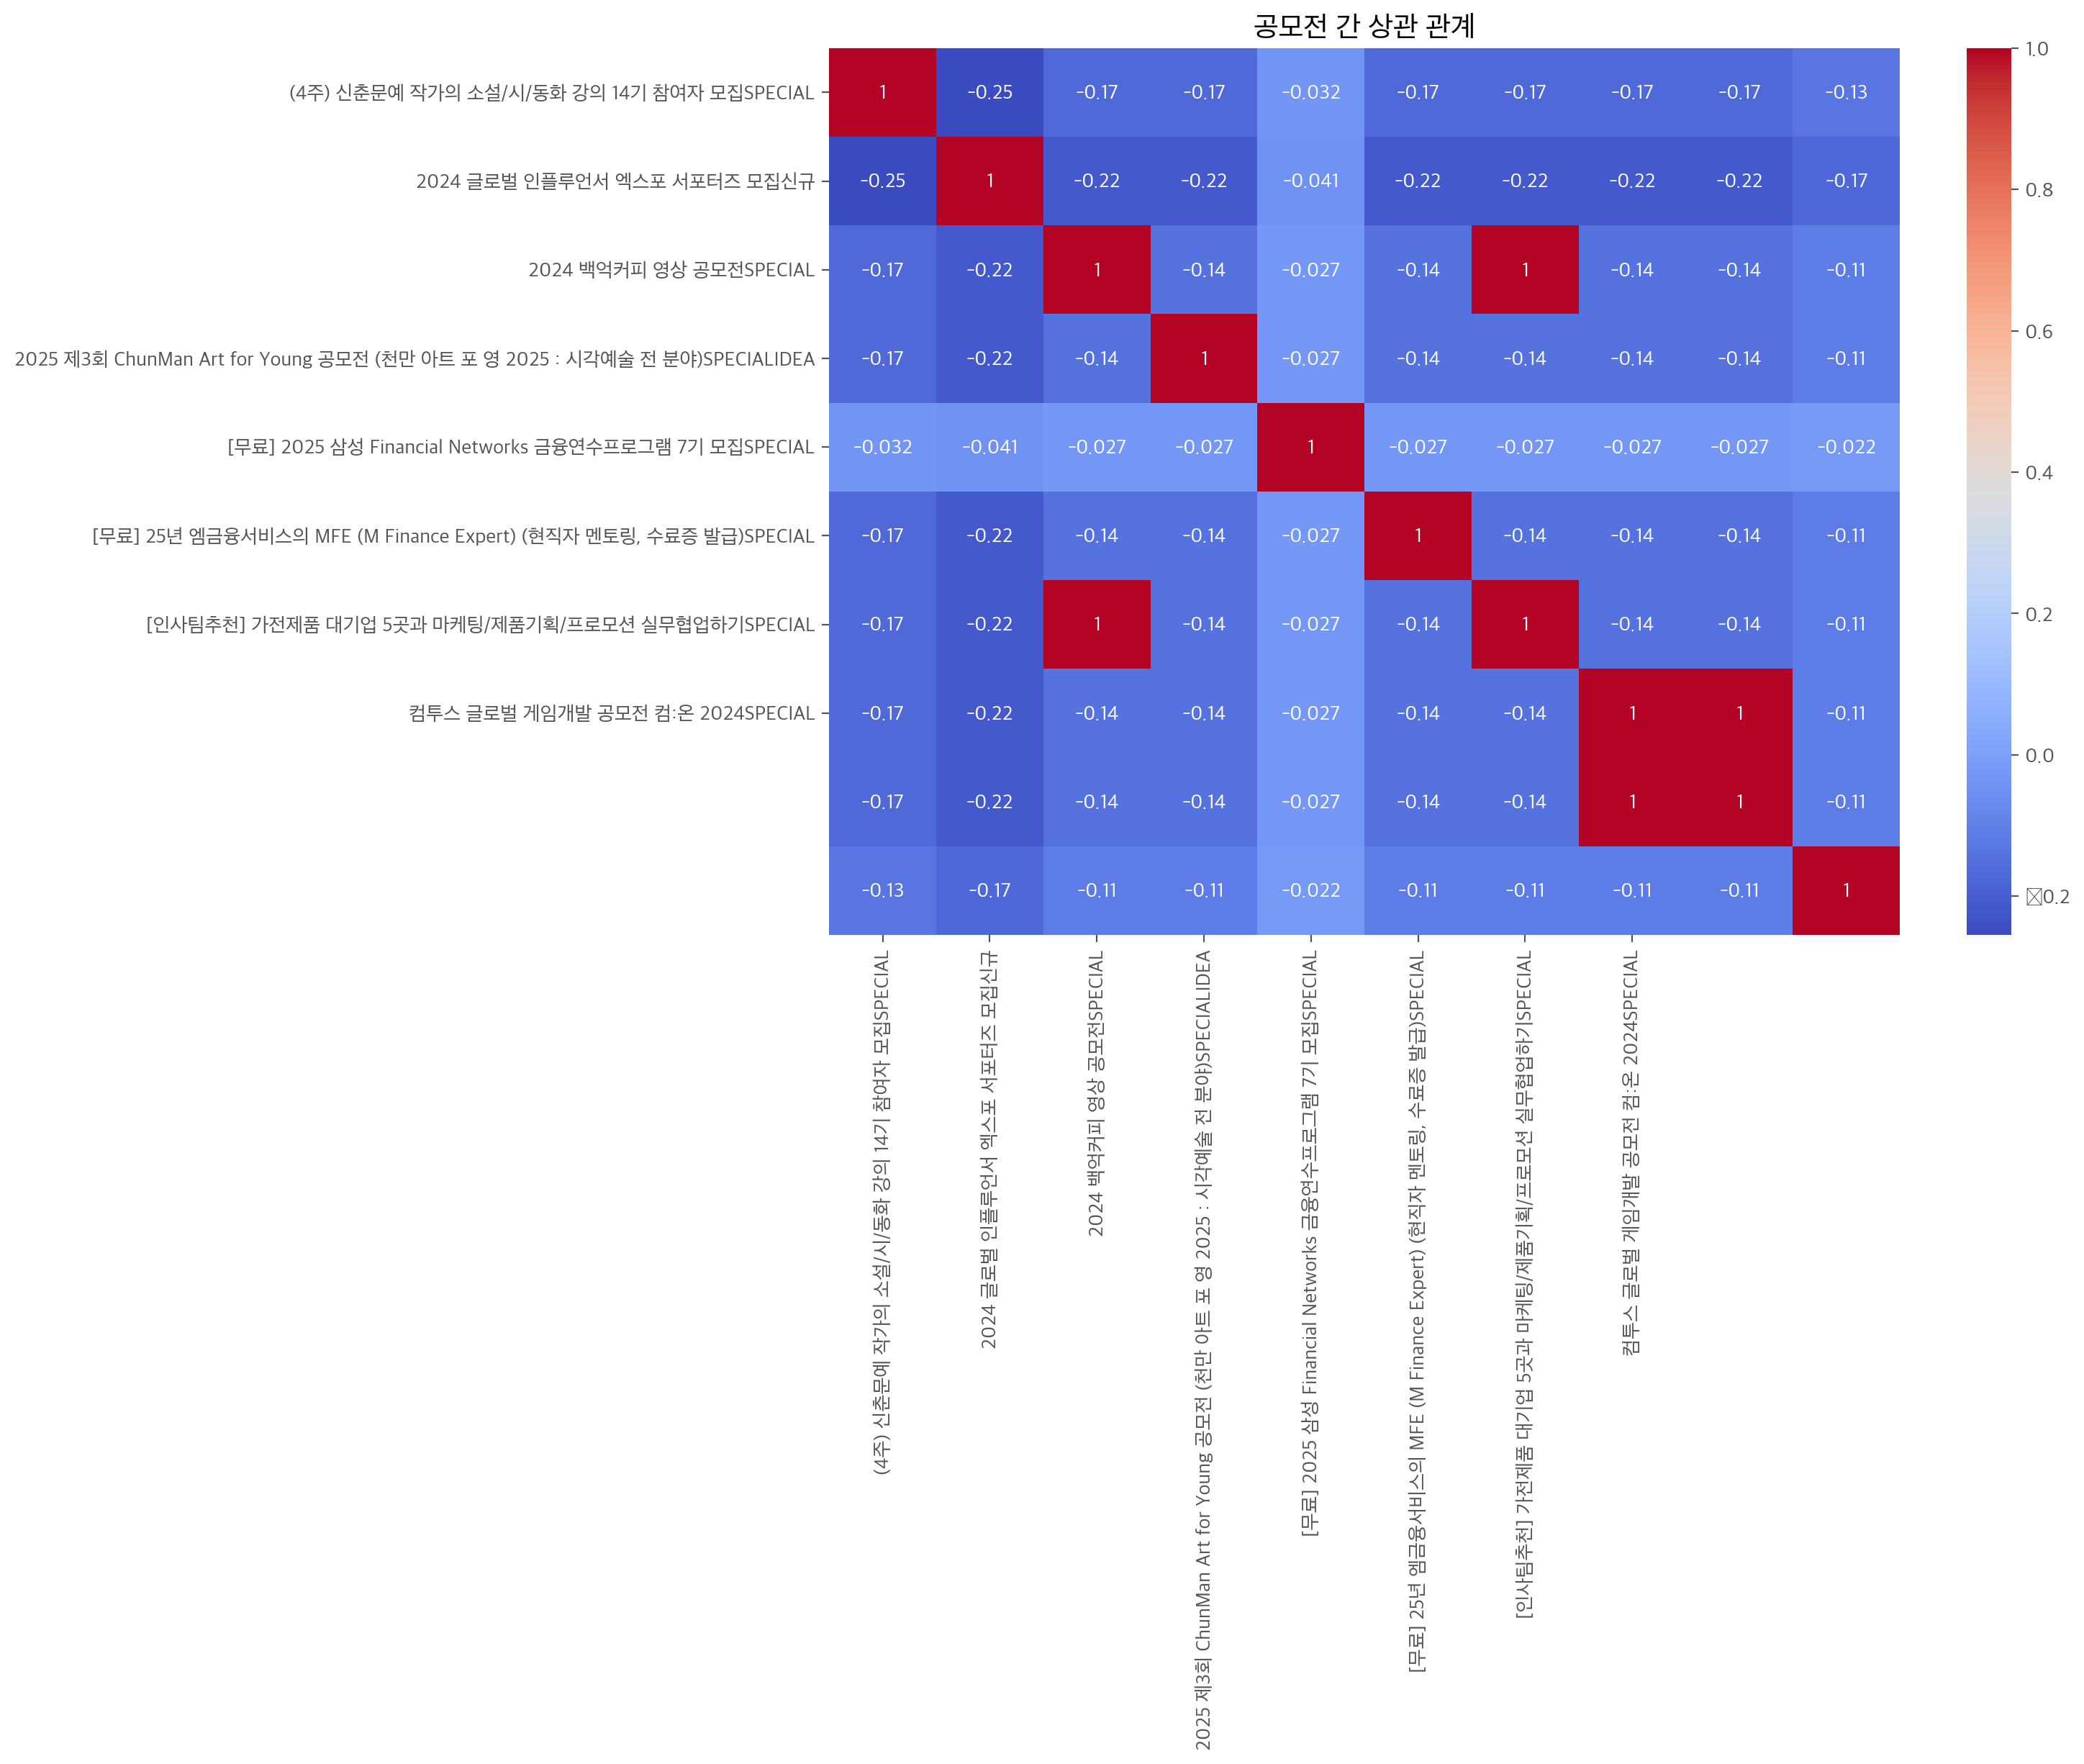

공모전 목록:
(4주) 신춘문예 작가의 소설/시/동화 강의 14기 참여자 모집special
2024 글로벌 인플루언서 엑스포 서포터즈 모집신규
2024 백억커피 영상 공모전special
2025 제3회 chunman art for young 공모전 (천만 아트 포 영 2025 : 시각예술 전 분야)specialidea
[무료] 2025 삼성 financial networks 금융연수프로그램 7기 모집special
[무료] 25년 엠금융서비스의 mfe (m finance expert) (현직자 멘토링, 수료증 발급)special
[인사팀추천] 가전제품 대기업 5곳과 마케팅/제품기획/프로모션 실무협업하기special
컴투스 글로벌 게임개발 공모전 컴:온 2024special


IndexError: list index out of range

In [64]:
import random as rd
import pandas as pd
import numpy as np
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# 데이터 로드 (공모전 데이터)
gong_info = pd.read_csv('./competitions.csv')

# 임의 유저 데이터 생성 (예시)
user_info = pd.DataFrame({
    'user_id': [f'user_{i}' for i in range(1, 11)],  # 10명의 사용자
    'gong_id': [rd.choice(gong_info.index) for _ in range(10)],  # 임의로 공모전 선택
    'gong_rank': [rd.randint(1, 5) for _ in range(10)]  # 임의로 1~5까지의 평가
})

# 공모전 데이터 가공 (필요한 열만 추출)
gong_data = gong_info[['공모명', '주최 기관', '분야']].copy()
gong_data['gong_id'] = gong_info.index  # 고유한 공모전 ID 추가

# 사용자-공모전 행렬 생성
user_gong_data = pd.merge(user_info, gong_data, on='gong_id')

# 사용자-공모전 평점 행렬 생성 (결측치는 0으로 채운다)
user_gong_rating = user_gong_data.pivot_table('gong_rank', index='user_id', columns='공모명').fillna(0)

# SVD 모델 적용
n_components = min(12, user_gong_rating.shape[1])  # 공모전 수보다 더 큰 n_components를 방지
SVD = TruncatedSVD(n_components=n_components)  # 주성분 개수를 공모전 수에 맞게 설정
matrix = SVD.fit_transform(user_gong_rating.values)

# 유사도 계산 (공모전 간 상관 관계)
corr = np.corrcoef(matrix)

# 시각화
plt.figure(figsize=(12, 8))
sns.heatmap(corr, cmap='coolwarm', annot=True, xticklabels=user_gong_rating.columns, yticklabels=user_gong_rating.columns)
plt.title('공모전 간 상관 관계')
plt.show()

# 추천 함수 정의
def recommend_competitions(user_title, corr_matrix, gong_titles, threshold=0.8):
    # 공모전 제목을 비교하기 쉽게 처리 (공백 제거, 소문자 처리 등)
    user_title_cleaned = user_title.strip().lower()  # 공백 제거하고 소문자로 변환
    
    # gong_titles에 있는 제목들도 소문자와 공백 제거 처리
    gong_titles_cleaned = [title.strip().lower() for title in gong_titles]
    
    # gong_titles의 목록 출력 (정확한 제목을 확인하기 위해)
    print("공모전 목록:")
    for title in gong_titles_cleaned:
        print(title)
    
    # 입력된 공모전 제목의 인덱스 찾기
    if user_title_cleaned not in gong_titles_cleaned:
        print(f"'{user_title}' 공모전은 목록에 없습니다.")
        return []
    
    idx = gong_titles_cleaned.index(user_title_cleaned)
    
    # 해당 공모전과 유사도가 높은 공모전 찾기 (threshold 이상)
    similar_competitions = []
    for i, score in enumerate(corr_matrix[idx]):
        if score >= threshold and gong_titles_cleaned[i] != user_title_cleaned:
            similar_competitions.append(gong_titles[i])
    
    return similar_competitions

# 예시: '컴투스 글로벌 게임개발 공모전 컴:온 2024SPECIAL'와 비슷한 공모전 찾기
gong_titles = list(user_gong_rating.columns)
similar_comps = recommend_competitions('컴투스 글로벌 게임개발 공모전 컴:온 2024SPECIAL', corr, gong_titles)

print("추천된 공모전들:", similar_comps)


In [80]:
# 데이터 마이닝 

pip install konlpy


SyntaxError: invalid syntax (3542271092.py, line 3)

In [73]:
import pandas as pd
import re
import time

import warnings
warnings.filterwarnings('ignore')

# 영어 특수문자 제거
def regular_cleaner(d, c):
    for i in range(len(d[c])):
        try:
            d[c][i] = re.sub('[^ 0-9|ㄱ-힗]+','',d[c][i])
            
        except:
            print(i)
            
# 텍스트 클리닝 함수
def test(s):
    hangul = re.compile('[^ ㄱ-ㅣ가-힣]+') # 한글과 띄어쓰기를 제외한 모든 글자
    # hangul = re.compile('[^ \u3131-\u3163\uac00-\ud7a3]+')  # 위와 동일
    result = hangul.sub('', s) # 한글과 띄어쓰기를 제외한 모든 부분을 제거
    print (result)

    result = hangul.findall(s) # 정규식에 일치되는 부분을 리스트 형태로 저장
    print (result)


df_text_ori = pd.read_csv('competitions.csv')
df_text = df_text_ori.copy()



In [79]:
from konlpy.tag import Kkma
from konlpy.utils import pprint
import io

kkma = Kkma()
df_text['상금추출'] =''
p = len(df_text) - 1
for j in range(0, p):
    st_time = time.time()
    s = io.StringIO()
    money_list = list(filter(lambda x : '만원' in s.getvalue().split('\n')[x]))
    for i in money_list:
        df_text['상금추출'][j] += (s.getvalue().split('\n')[i])
 
    if j%10 == 0 :
        ed_time = time.time() - st_time
        print('\r남은 개수 :',j,'/',p,'\t\t남은 시간 :',round(ed_time*(p-j-1),2), '\t\t', end='')

TypeError: filter expected 2 arguments, got 1